In [ ]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

project_root = Path(__file__).resolve().parents[2] if "__file__" in globals() else Path().resolve().parents[1]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from paths import DATA_DIR 

sns.set_theme(context="notebook", style="whitegrid")
pd.options.display.width = 120


In [ ]:
data = pd.read_parquet(DATA_DIR / "train.parquet")
data_test = pd.read_parquet(DATA_DIR / "final_test.parquet")

if not pd.api.types.is_datetime64_any_dtype(data["date"]):
    data["date"] = pd.to_datetime(data["date"])

data.head()


,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [3]:
print("Shape:", data.shape)

display(
    pd.DataFrame(
        {
            "nunique": data.nunique(axis=0).sort_values(ascending=False)
        }
    ).T
)


Shape: (496827, 12)


,date,bike_count,log_bike_count,counter_id,counter_name,site_id,site_name,coordinates,counter_technical_id,latitude,longitude,counter_installation_date
nunique,8974,998,998,56,56,30,30,30,30,30,30,22


**ID / name correspondence checks**
- Counter Name ↔ Counter ID (expect mostly 1–1)
- Counter Name ↔ Counter Technical ID (can be 1–many)
- Site Name ↔ Site ID (expect 1–1)
- Site ID ↔ Counter Technical ID (often 1–1 given installation)


In [4]:
print("Counter Name ↔ Counter ID:", data[["counter_name", "counter_id"]].drop_duplicates().shape)
print("Counter Name ↔ Counter Technical ID:", data[["counter_name", "counter_technical_id"]].drop_duplicates().shape)
print("Site Name ↔ Site ID:", data[["site_name", "site_id"]].drop_duplicates().shape)
print("Site ID ↔ Counter Technical ID:", data[["site_id", "counter_technical_id"]].drop_duplicates().shape)


Counter Name ↔ Counter ID: (56, 2)
Counter Name ↔ Counter Technical ID: (56, 2)
Site Name ↔ Site ID: (30, 2)
Site ID ↔ Counter Technical ID: (30, 2)


In [5]:
top10 = (
    data.groupby(["site_name", "counter_name"])["bike_count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame("total_bikes")
    .reset_index()
)
top10


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_78665/2543682210.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"]


,site_name,counter_name,total_bikes
0,Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
1,Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
2,Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
3,67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
4,Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
5,27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
6,Quai d'Orsay,Quai d'Orsay E-O,948357.0
7,Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
8,Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0
9,Face au 48 quai de la marne,Face au 48 quai de la marne NE-SO,833657.0


### Monthly log bike counts across counters

Pivot (month × counter_name) and plot a heatmap of summed **log_bike_count**.


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_78665/4070119658.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = data.assign(month=data["date"].dt.to_period("M")).pivot_table(


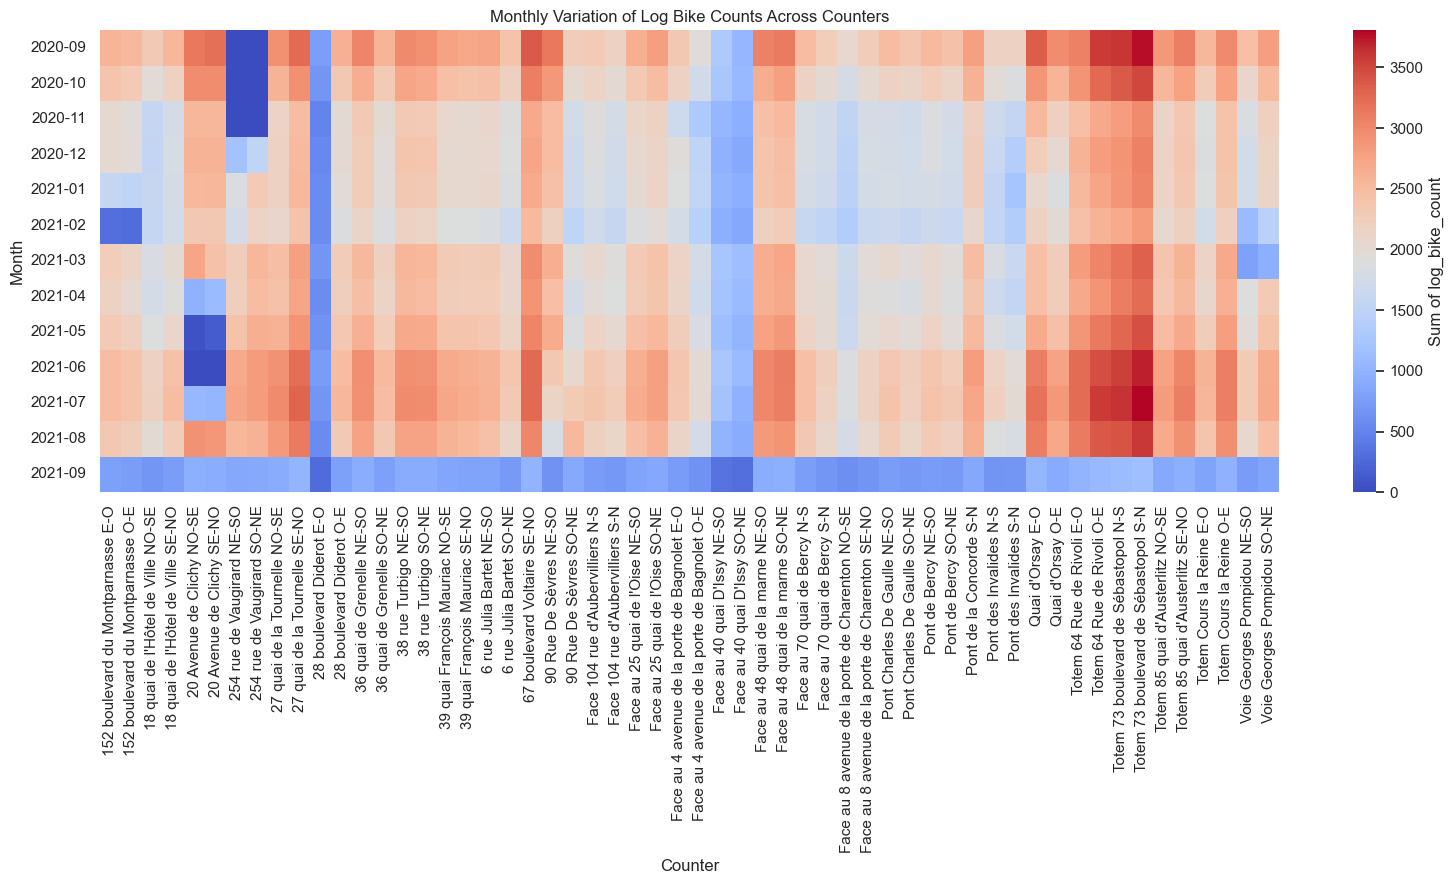

In [ ]:
heatmap_data = data.assign(month=data["date"].dt.to_period("M")).pivot_table(
    index="month",
    columns="counter_name",
    values="log_bike_count",
    aggfunc="sum",
    fill_value=0.0,
)

plt.figure(figsize=(16, 9))
sns.heatmap(heatmap_data, cmap="coolwarm", cbar_kws={"label": "Sum of log_bike_count"})
plt.title("Monthly Variation of Log Bike Counts Across Counters")
plt.xlabel("Counter")
plt.ylabel("Month")
plt.tight_layout()
plt.show()


**Notes**
1. Some counters show near-zero months (e.g., outages / newly installed periods).
2. Clear common seasonal structure across most counters.


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_78665/2024710273.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["counter_id", pd.Grouper(freq="1D", key="date")])["log_bike_count"]


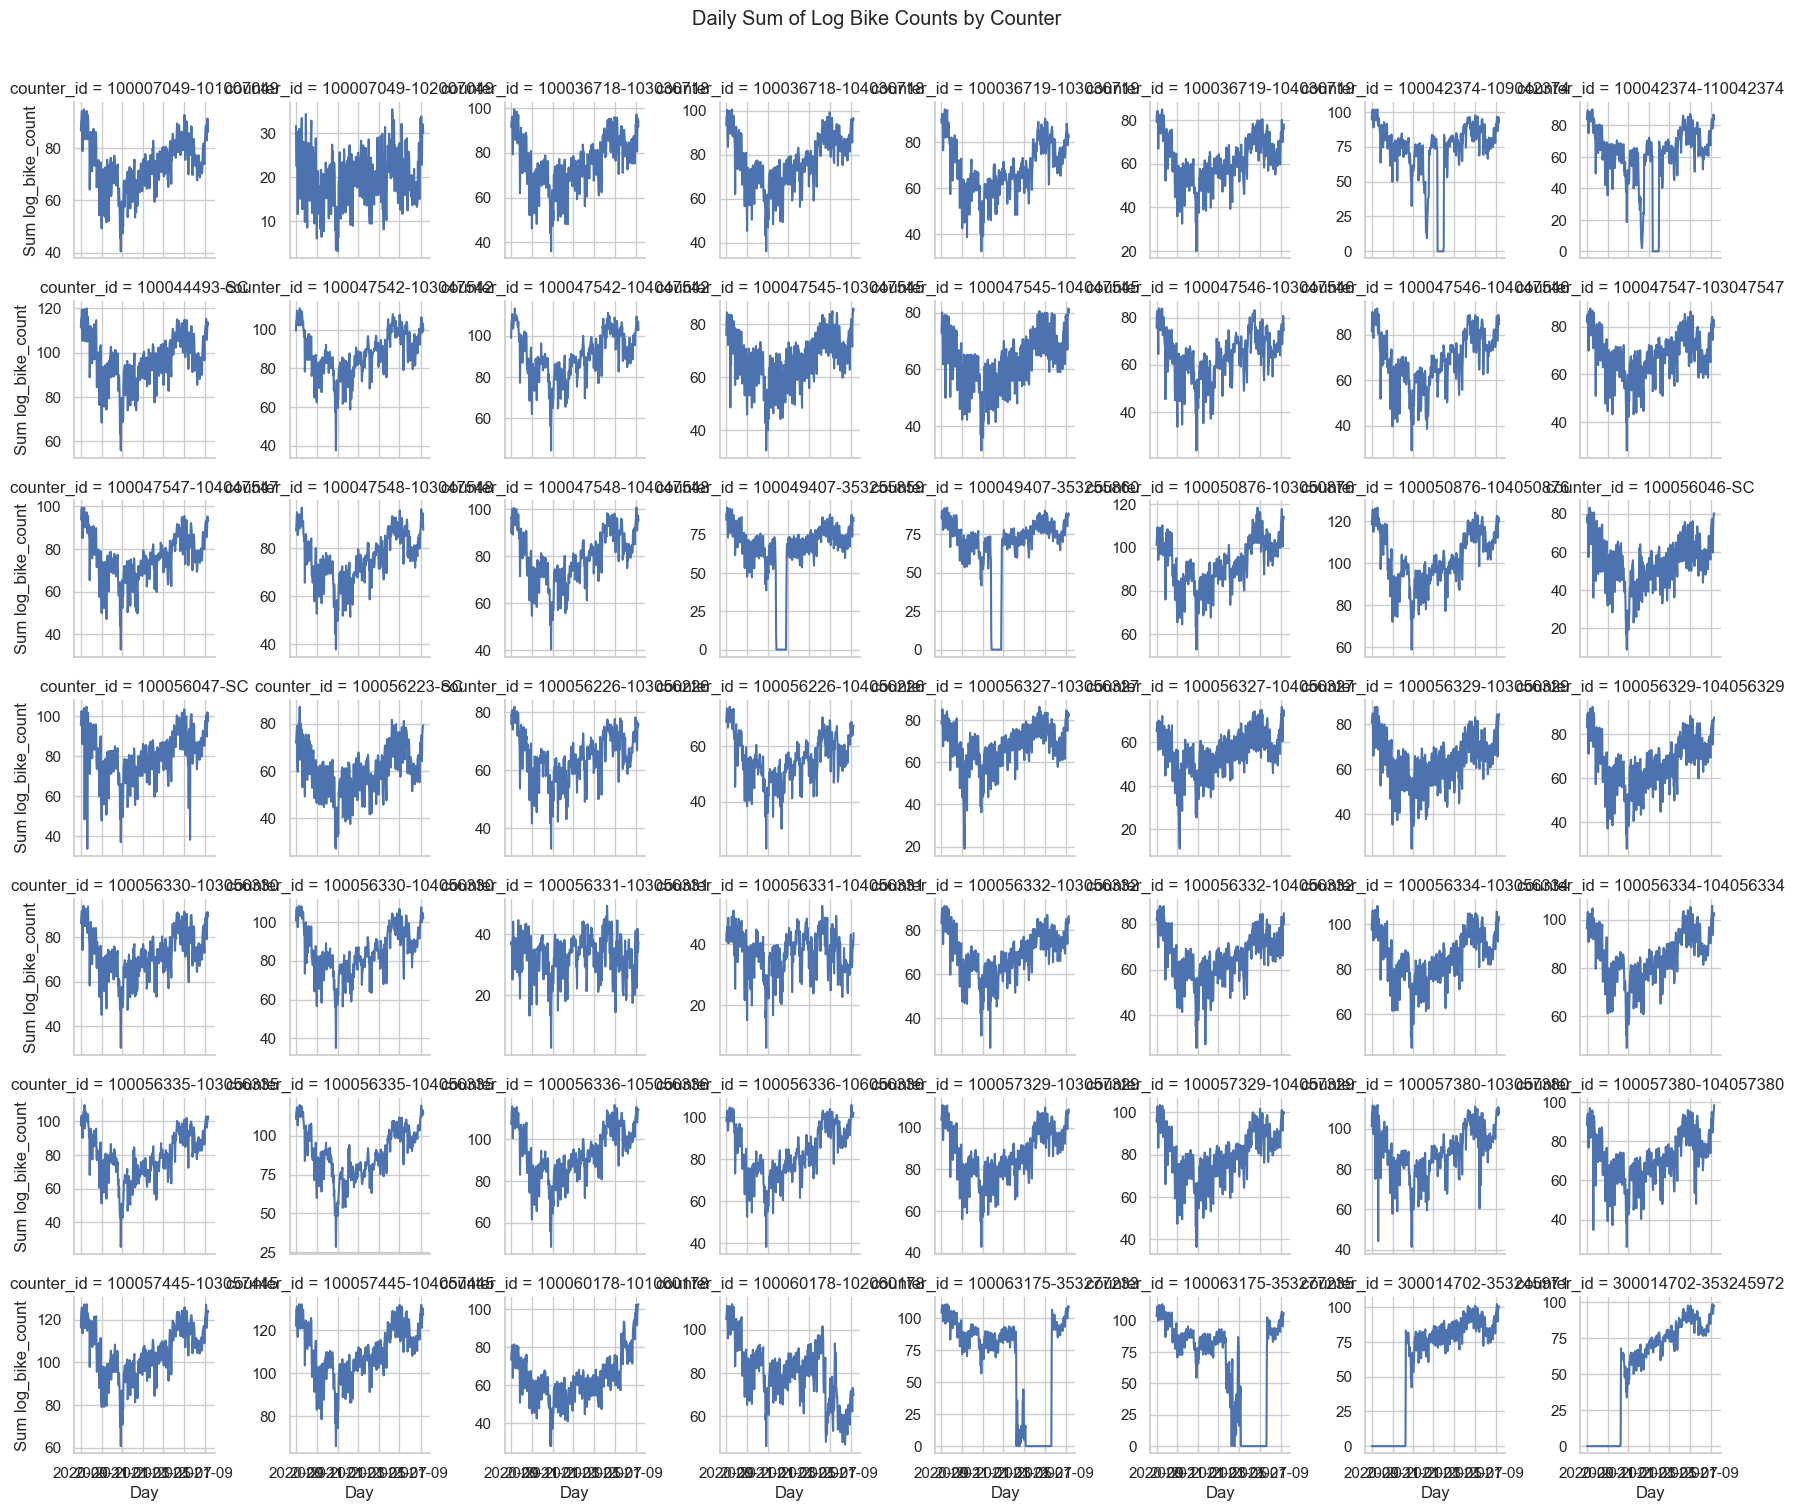

In [7]:
grouped_daily = (
    data.groupby(["counter_id", pd.Grouper(freq="1D", key="date")])["log_bike_count"]
    .sum()
    .reset_index()
    .rename(columns={"date": "day"})
)

g = sns.FacetGrid(grouped_daily, col="counter_id", col_wrap=8, height=2.2, sharey=False)
g.map(sns.lineplot, "day", "log_bike_count")
g.set_axis_labels("Day", "Sum log_bike_count")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Daily Sum of Log Bike Counts by Counter")
plt.show()


**Outlier rule:** drop *entire days per counter* where total `log_bike_count == 0`
(offline counters / pre-installation periods).


In [8]:
data["date_truncated"] = data["date"].dt.floor("D")

zero_days = (
    data.groupby(["counter_id", "date_truncated"])["log_bike_count"]
    .sum()
    .reset_index()
    .query("log_bike_count == 0")[["counter_id", "date_truncated"]]
)

filtered_data = (
    zero_days
    .merge(data, on=["counter_id", "date_truncated"], how="right", indicator=True)
    .query("_merge == 'right_only'")
    .drop(columns=["_merge", "date_truncated"])
)

print(f"Eliminated {data.shape[0] - filtered_data.shape[0]} rows out of {data.shape[0]} due to zero-days.")
filtered_data.head()


Eliminated 5208 rows out of 496827 due to zero-days.


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_78665/775789503.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["counter_id", "date_truncated"])["log_bike_count"]


,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_78665/1065036320.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data["hour_truncated"] = data["date"].dt.floor("H")


<Figure size 1000x500 with 0 Axes>

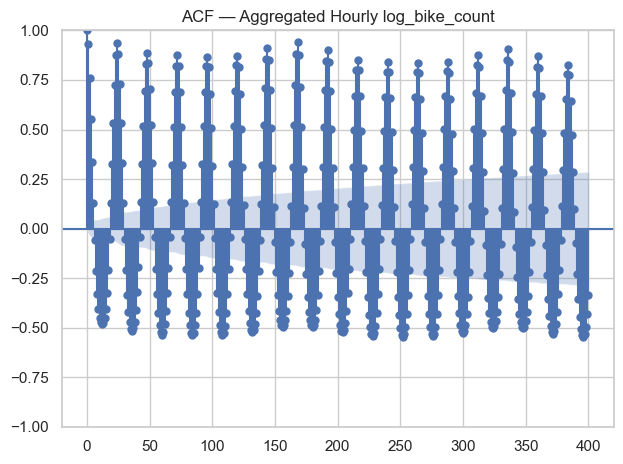

In [9]:
# aggregate hourly across counters (using original data to keep full horizon)
data["hour_truncated"] = data["date"].dt.floor("H")

hourly_agg = (
    data.groupby("hour_truncated")["log_bike_count"]
    .sum()
    .sort_index()
)

plt.figure(figsize=(10, 5))
plot_acf(hourly_agg, lags=400, alpha=0.05, title="ACF — Aggregated Hourly log_bike_count")
plt.tight_layout()
plt.show()


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_78665/647383064.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["counter_id", "day_of_week"])["log_bike_count"]


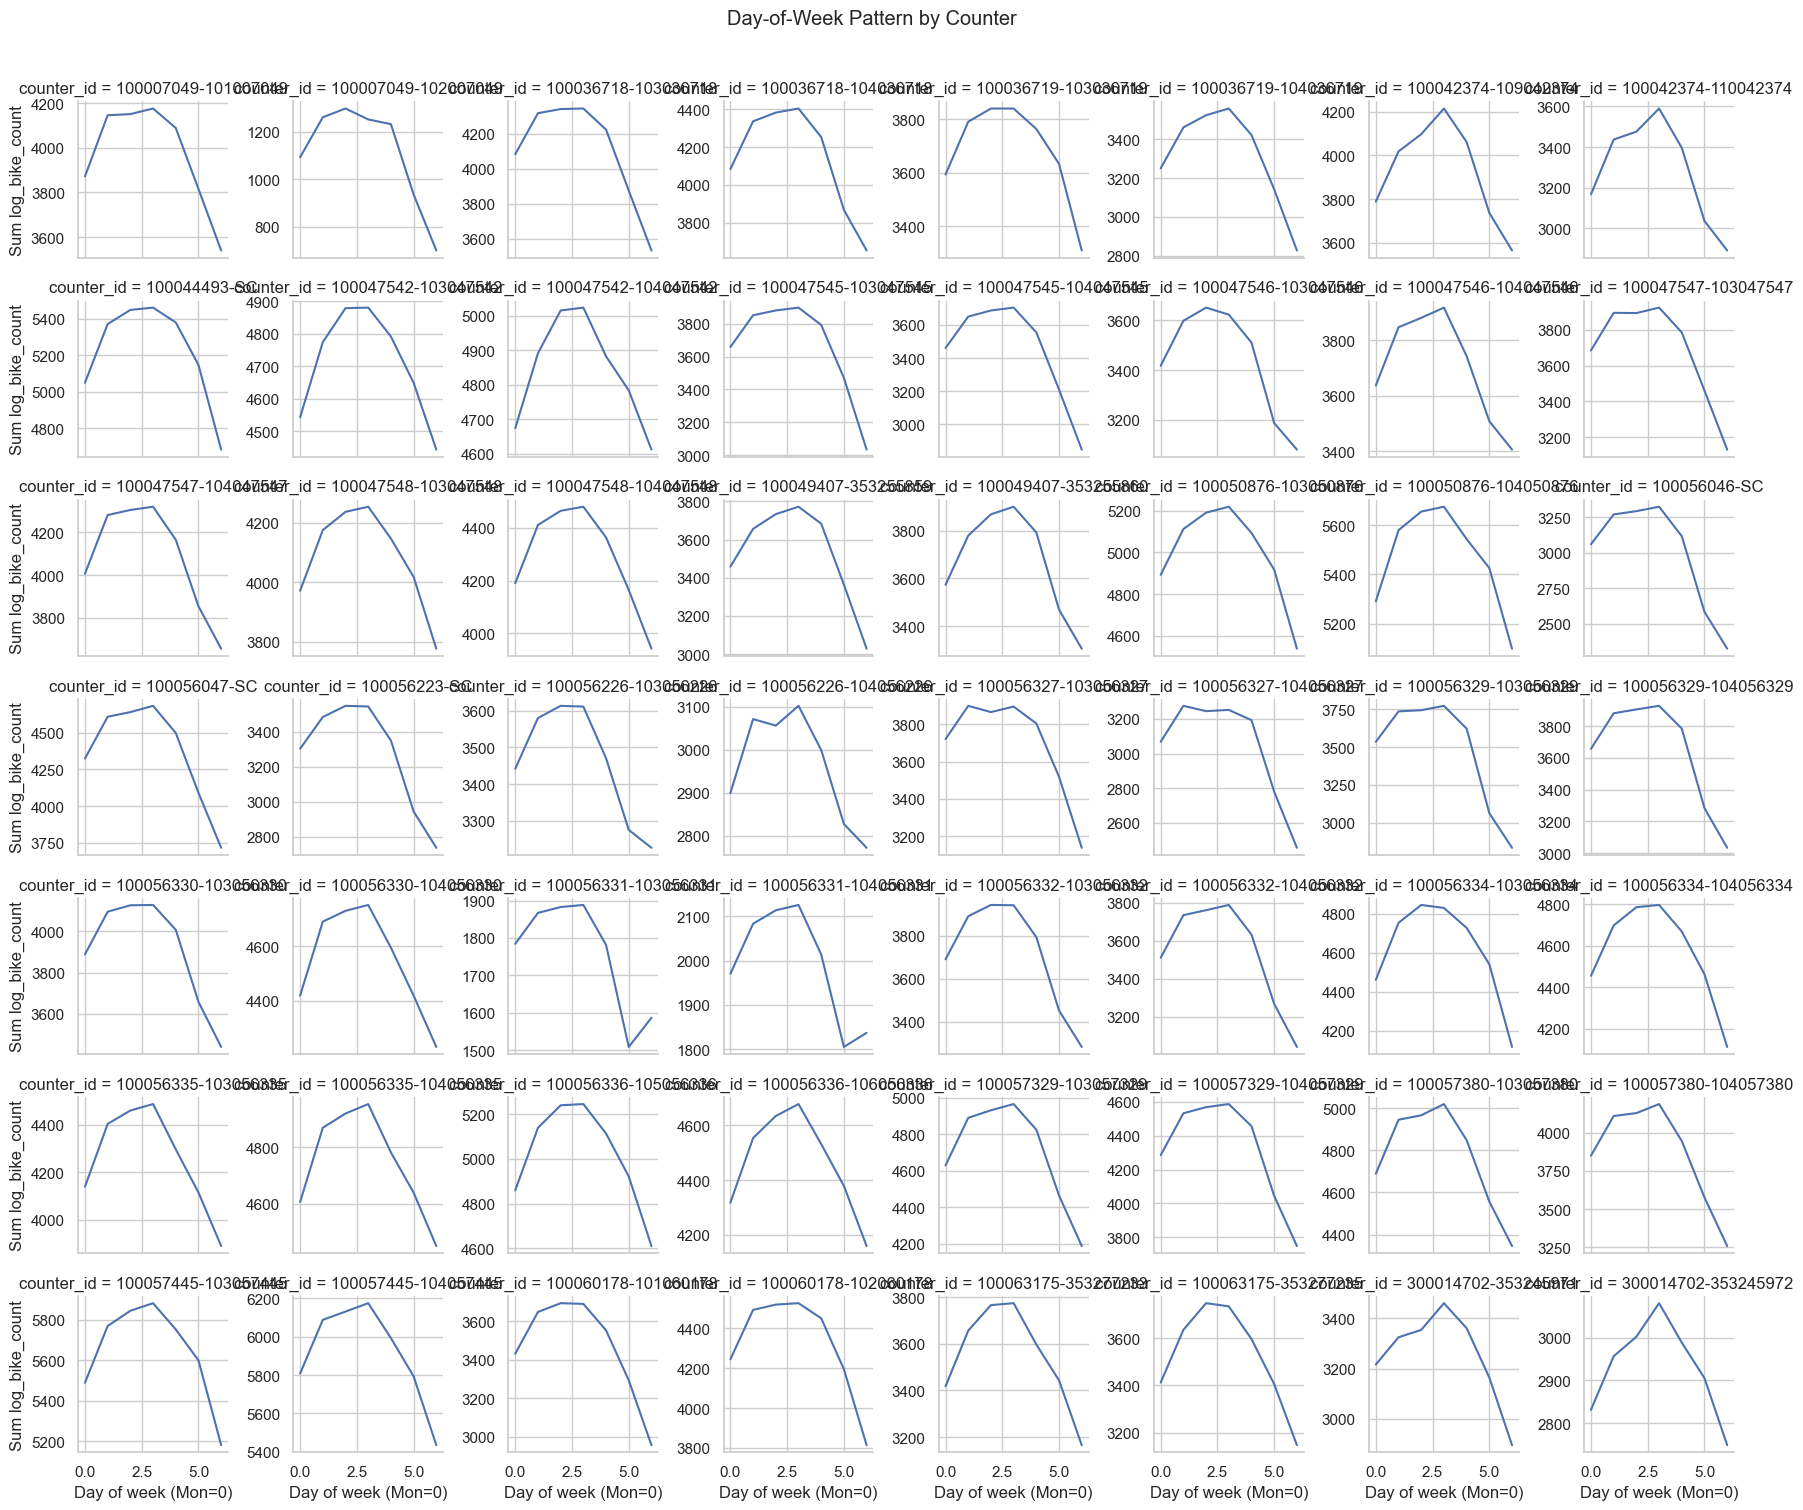

In [10]:
data["day_of_week"] = data["date"].dt.dayofweek

dow = (
    data.groupby(["counter_id", "day_of_week"])["log_bike_count"]
    .sum()
    .reset_index()
)

g = sns.FacetGrid(dow, col="counter_id", col_wrap=8, height=2.2, sharey=False)
g.map(sns.lineplot, "day_of_week", "log_bike_count")
g.set_axis_labels("Day of week (Mon=0)", "Sum log_bike_count")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Day-of-Week Pattern by Counter")
plt.show()


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_78665/2912309301.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["counter_id", "day_of_week", "hour"])["log_bike_count"]


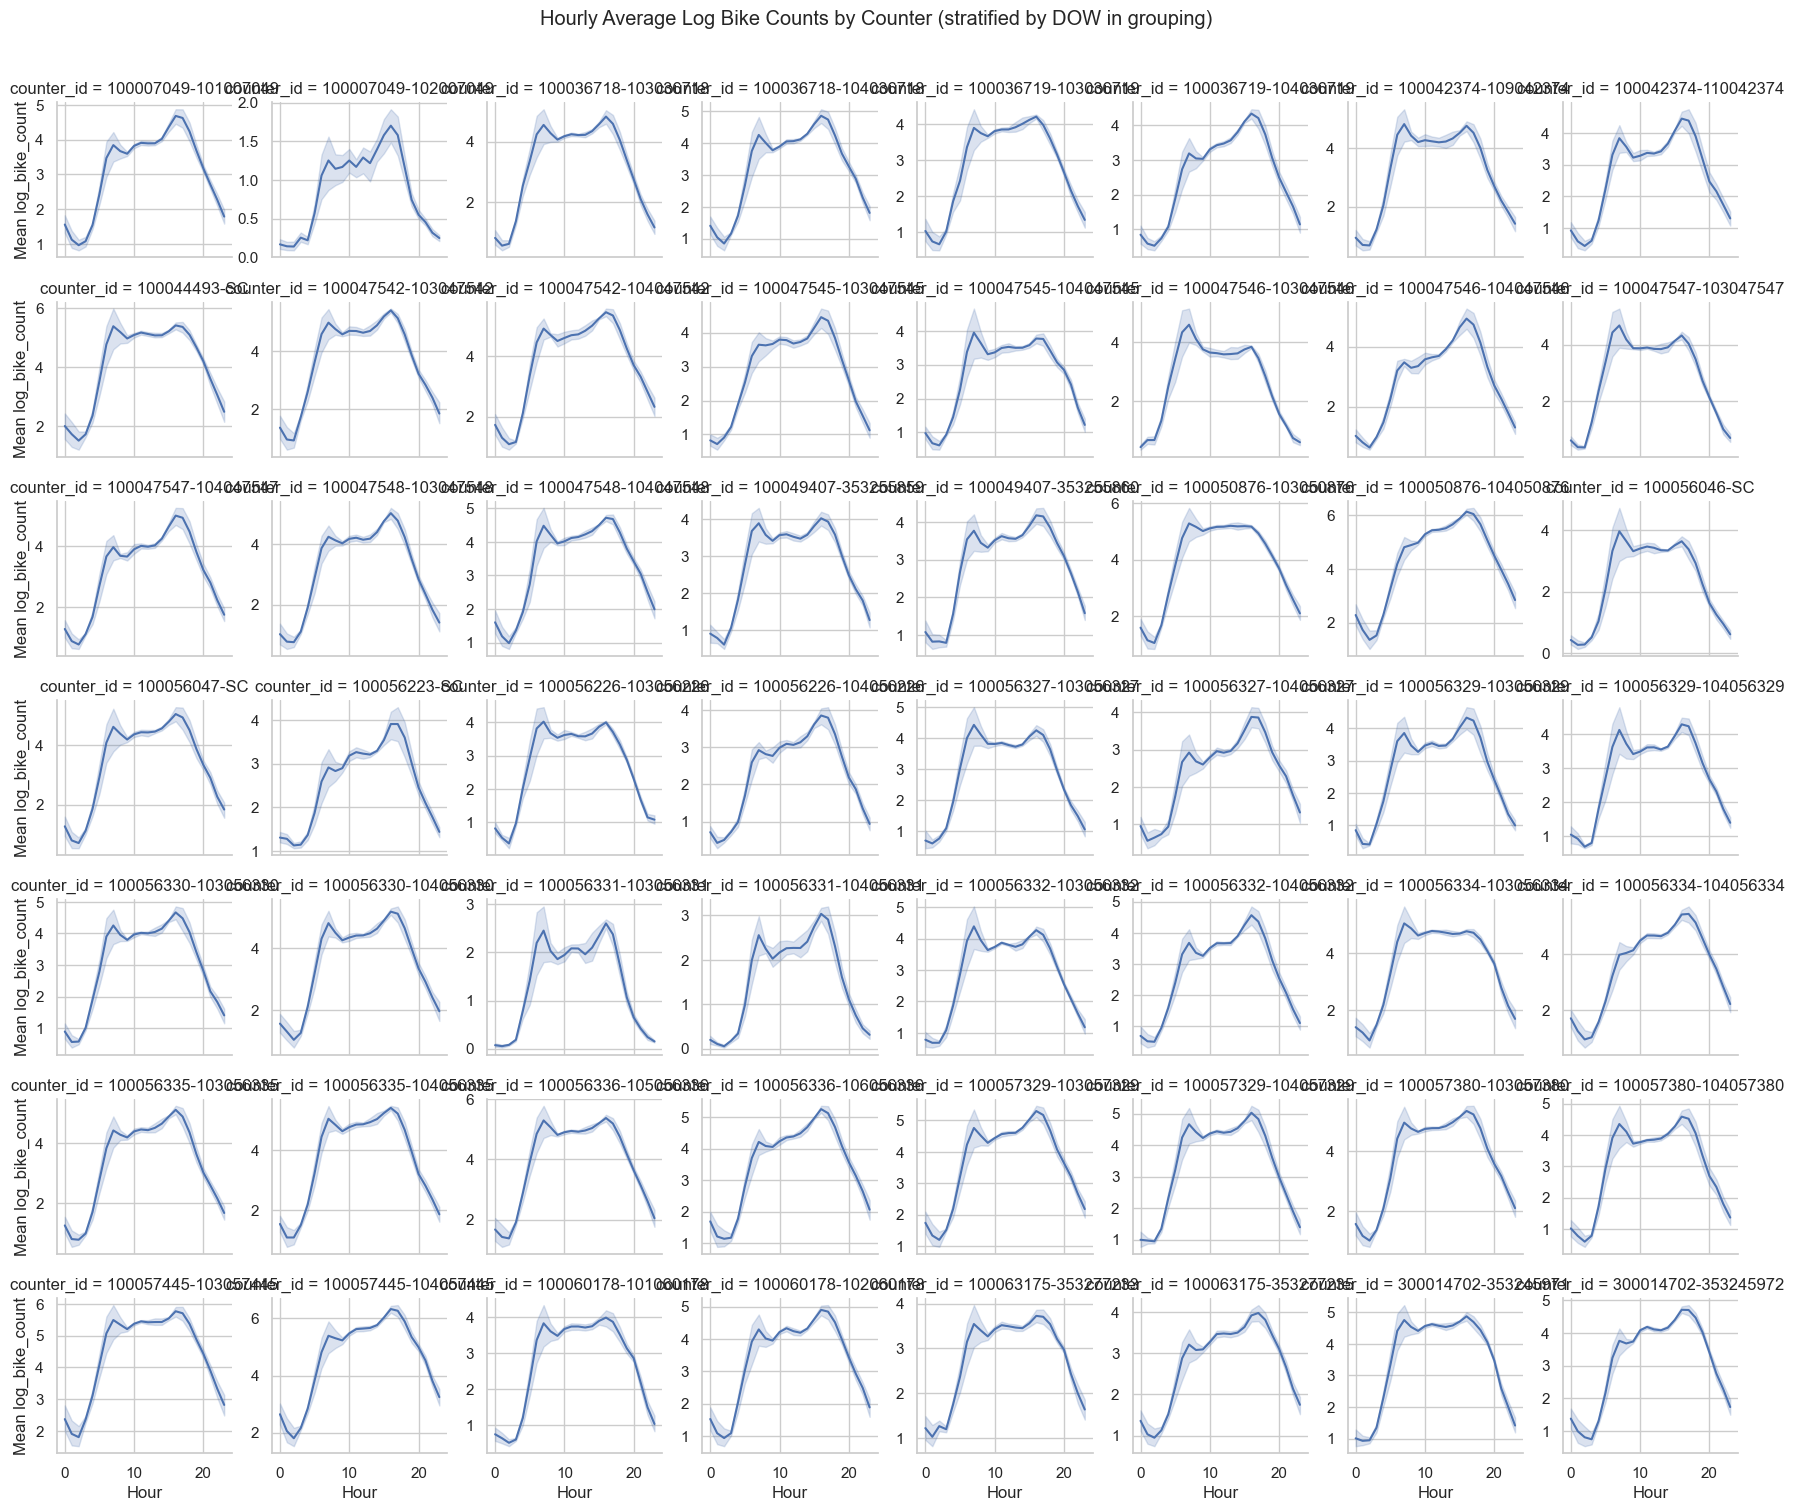

In [11]:
data["hour"] = data["date"].dt.hour

hourly_profile = (
    data.groupby(["counter_id", "day_of_week", "hour"])["log_bike_count"]
    .mean()
    .reset_index()
)

g = sns.FacetGrid(hourly_profile, col="counter_id", col_wrap=8, height=2.2, sharey=False)
g.map(sns.lineplot, "hour", "log_bike_count")
g.set_axis_labels("Hour", "Mean log_bike_count")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Hourly Average Log Bike Counts by Counter (stratified by DOW in grouping)")
plt.show()


### Installation timing vs. cumulative usage
Scatter: station installation date vs. total log bike counts per site.


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_78665/2368054906.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name"])["log_bike_count"].sum().to_frame("sum_log_count")


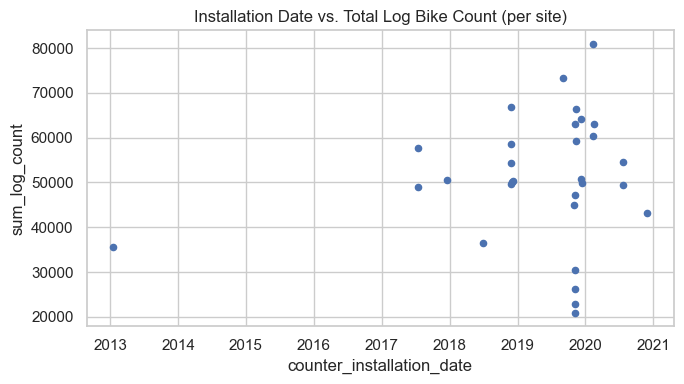

In [12]:
install_scatter = (
    data.groupby(["site_name"])["log_bike_count"].sum().to_frame("sum_log_count")
    .merge(
        data[["site_name", "counter_installation_date"]].drop_duplicates(),
        on="site_name",
        how="left"
    )
)

ax = install_scatter.sort_values("counter_installation_date").plot.scatter(
    x="counter_installation_date", y="sum_log_count", figsize=(7, 4), title="Installation Date vs. Total Log Bike Count (per site)"
)
plt.tight_layout()
plt.show()
